# **PROYECTO SPRINT 13: PRONÓSTICOS Y PREDICCIONES**

*Andrea Linette Mézquita Gómez*

## **INTRODUCCIÓN**

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con clientes basada en datos analíticos.

Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un/a cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un/a cliente se haya ido: puede que se vaya de puntillas.

Los indicadores de pérdida varían de un campo a otro. Si un usuario o una usuaria compra en una tienda en línea con poca frecuencia, pero con regularidad, no se puede decir que ha huido. Pero si durante dos semanas no ha abierto un canal que se actualiza a diario, es motivo de preocupación: es posible que tu seguidor o seguidor/a se haya aburrido y te haya abandonado.

En el caso de un gimnasio, tiene sentido decir que un/a cliente se ha ido si no viene durante un mes. Por supuesto, es posible que estén en Cancún y retomen sus visitas cuando regresen, pero ese no es un caso típico. Por lo general, si un/a cliente se une, viene varias veces y luego desaparece, es poco probable que regrese.

Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Tu tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

**Tienes que:**

* Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.
* Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.
* Analizar los factores que más impactan la pérdida.
* Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    * identificar a los grupos objetivo;
    * sugerir medidas para reducir la rotación;
    * describir cualquier otro patrón que observes con respecto a la interacción con los clientes.

**El dataset incluye los siguientes campos:**

* 'Churn' — la cancelación para el mes en cuestión

**Campos de dataset actuales:**
* Datos del usuario del mes anterior
* 'gender'.
* 'Near_Location' — si el/la usuario/a vive o trabaja en el vecindario donde se encuentra el gimnasio.
* 'Partner' — si el/la usuario/a trabaja en una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes).
* Promo_friends — si el/la usuario/a originalmente se inscribió mediante una oferta “trae a un/a amigo/a” (se utilizó el código promocional de un/a amigo/a cuando pagaron el primer abono).
* 'Phone' — si el/la usuario/a aportó el número de teléfono.
* 'Age'.
* 'Lifetime' — el tiempo (en meses) desde que el/la usuario/a llegó por primera vez al gimnasio.

**Datos del registro de visitas y compras y datos sobre el estado actual de la membresía:**
* 'Contract_period' — 1 mes, 3 meses, 6 meses o 1 año.
* 'Month_to_end_contract' — los meses que faltan hasta que expire el contrato.
* 'Group_visits' — si el/la usuario/a participa en sesiones grupales.
* 'Avg_class_frequency_total' — frecuencia media de visitas por semana a lo largo de la vida del cliente.
* 'Avg_class_frequency_current_month' — frecuencia media de visitas por semana durante el mes en curso.
* 'Avg_additional_charges_total' — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

## **ANÁLISIS EXPLORATORIO DE DATOS (EDA)**

In [2]:
# Importamos librerías
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

**Cargamos el archivo**

In [3]:
df = pd.read_csv("gym_churn_us.csv")

**Observamos el dataset**

In [4]:
# Imprimimos las primeras filas del dataframe
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Columnas categóricas o binarias:
* gender
* near_location
* partner
* promo_friends
* phone
* contract_period (1, 3, 6, 12)
* group_visits
* churn

Columnas numéricas:
* age
* avg_additional_charges_total
* month_to_end_contract
* lifetime
* avg_class_frequency_total
* avg_class_frequency_current_month


In [5]:
# Imprimimos la información del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
# Cambiamos el nombre de las columnas a minúsculas
df.columns = df.columns.str.lower()

In [7]:
# Imprimimos la descripción del dataframe
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Observación:**
*Tomando en cuenta que que 0=No y 1=Si*
* **Gender:** pareciera que estan distribuidos uniformemente, es decir, casi el 50% son hombres y el 50% mujeres
* **near_location:** en promedio el 80% de las personas se encuentran cerca del gym
* **partner:** el 48% de las personas trabajan en una compañía asociada al gimnasio
* **promo_friends**: solamente el 30% fueron invitados por la promo friends
* **contract_period**: en promedio, las personas suelen contratar entre 4-5 meses, es decir, entre 3 y 6, aunque el 50% de los datos marca que el contrato de 1 mes es el más común o solicitado.
* **group_visits**: el 41% de las personas asisten en sesiones grupales
* **age**: en promedio las personas tienen 29 años, o bien, el 50% de los usuarios tienen al rededor de 29 años y el 75% 31 años, por lo que en general, los clientes son usuarios jóvenes 
* **avg_additional_charges_total**: en promedio suelen gastar $146 en servicios adicionales del gimnasio
* **month_to_end_contract**: en promedio a los usuarios les faltan 4 meses hasta que termine su contrato, sin embargo, al 50% de los usuarios les queda solamente 1 mes.
* **lifetime**: los meses en promedio que han estado los usuarios desde que llegaron al gimnasio es de 3-4 meses, es decir, muchos usuarios tienen a estar pocos meses activos.
* **avg_class_frequency_total**: en promedio, los usuarios suelen asistir entre 1 y 2 clases por semana
* **churn**: el 50% de los usuarios suelen mantenerse en el gym, sin embargo, hay un 26% de usuarios que suelen cancelar su renovación del contrato.

**Distribución de conversión**

Podemos empezar a visualizar la distribución de nuestros datos de conversión para identificar si están desbalanceados, es decir, si hay una diferencia significativa entre las clases (por ejemplo, usuarios que cancelaron su contrato vs. los que no). Esto es importante porque un desequilibrio en los datos puede afectar negativamente el rendimiento de nuestro modelo de machine learning.

¿Por qué afecta que los datos estén desequilibrados?
1. **Predicciones sesgadas:**
Los modelos de machine learning tienden a favorecer la clase mayoritaria, ya que optimizan métricas como la precisión general. Esto puede llevar a que el modelo ignore o tenga un bajo rendimiento en la clase minoritaria.

2. **Métricas engañosas:**
En un conjunto de datos desbalanceado, una alta precisión no necesariamente indica un buen modelo. Por ejemplo, si el 90% de los datos pertenecen a una clase, un modelo que siempre prediga esa clase tendrá una precisión del 90%, pero no será útil para identificar la clase minoritaria.

3. **Impacto en la toma de decisiones:**
En problemas como la predicción de cancelación de usuarios, la clase minoritaria (usuarios que cancelan) suele ser la más importante, ya que queremos identificar y retener a esos clientes. Si el modelo no puede predecir correctamente esta clase, no cumplirá su propósito.

Visualizar la distribución de los datos es el primer paso para identificar si necesitamos aplicar alguna  estrategia.

churn
0    2939
1    1061
Name: count, dtype: int64


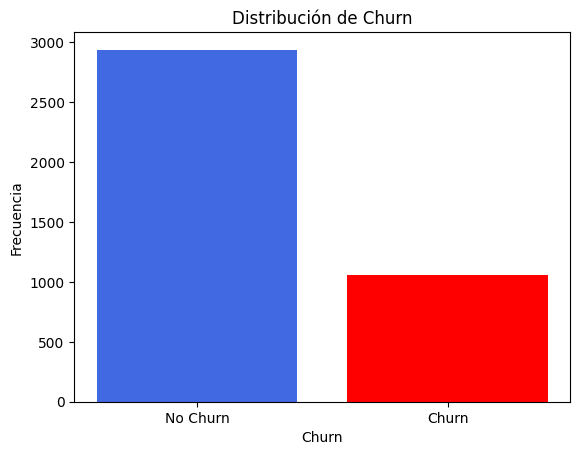

In [8]:
# Observamos la distribución de los datos de conversión
mean_churn = df.churn.value_counts()
print(mean_churn)
plt.bar(mean_churn.index, mean_churn.values, color=['royalblue', 'red'])
plt.xticks(mean_churn.index, ['No Churn', 'Churn'])
plt.xlabel('Churn')
plt.ylabel('Frecuencia')
plt.title('Distribución de Churn')
plt.show()

Como vimos anteriormente, la mayoría de los usuarios se mantienen en el gimnasio, sin embargo, esta distribución desbalanceada puede afectar nuestro modelo de pronóstico.

**Comportamiento promedio de las características de los usuarios que cancelaron su contrato vs los que siguen en el gimnasio**

In [9]:
# Valores promedio de las características por cada grupo de churn
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Comparando los grupos entre los que cancelaron su contrato, a pesar de que los usuarios viven cerca del gimnasio, el 76% decidió cancelar. 

Solamente el 35% y 18% de usuarios que trabajan en una compañía asociada al gimnasio o fueron invitados por un amigo, respectivamente, decidieron cancelar su contrato en el mes, es decir, los que trabajan en una compañía asociada o fueron invitados tienden a quedarse más en el gimnasio.

Por otro lado, la característica de duración del contrato (contract_period) indica que las personas que suelen cancelar su contrato es porque contratan solamente 1 mes. (¿Será buena idea eliminar ese plan?)

**Periodo de Contrato vs Características Cualitativas** 

Elegimos comparar la columna 'contract_period' porque muy posiblemente pudiera tener alguna relación con la fuga de clientes. Es por esto que queremos visualizar cómo afecta esta característica a nuestros usuarios en las características categóricas o binarias.

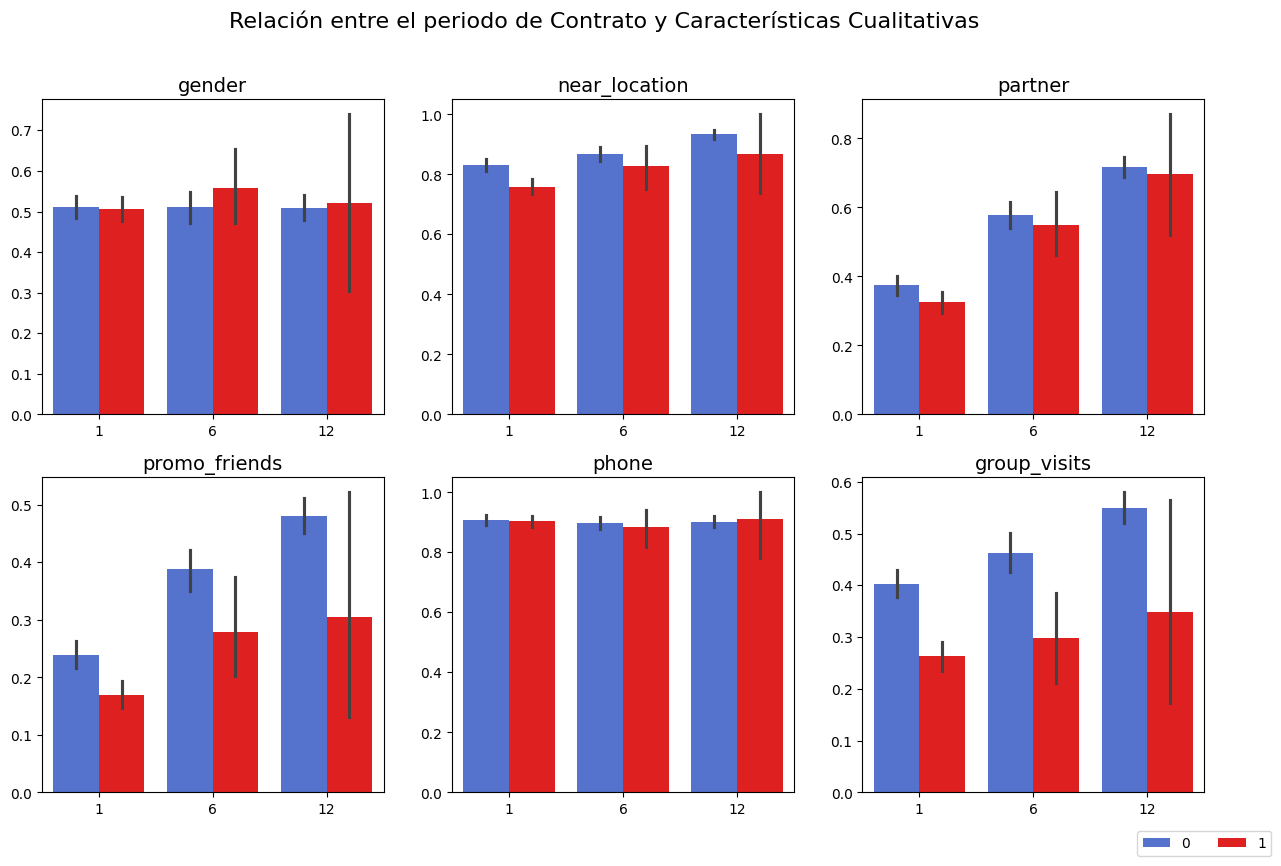

In [10]:
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
cols = 'royalblue','red'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,9))
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        sns.barplot(x='contract_period', y=columns[i], data=df, hue='churn', palette=cols, ax=ax)
        ax.legend([], [], frameon=False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{columns[i]}', fontsize=14)
    else:
        ax.axis('off')
plt.legend(loc='upper center', bbox_to_anchor=(1, -0.1), ncol=2, frameon=True)
fig.suptitle('Relación entre el periodo de Contrato y Características Cualitativas', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

**Análisis**

* La característica **gender(género)** no parece mostrar una relación significativa con el periodo de contrato. Tanto hombres como mujeres tienen una distribución similar en los diferentes periodos de contrato, lo que indica que esta variable *no influye directamente en la duración del contrato*.
* La característica **near_location(cercanía al gimnasio)** pareciera mostrar que los usuarios que viven cerca del gimnasio tienden a tener contratos más largos, lo que sugiere que la proximidad al gimnasio podría estar relacionada con una mayor retención. Sin embargo, esta diferencia no es muy marcada (podríamos aplicar prueba de hipótesis)
* La característica **partner(empleado de una empresa asociada)** muestra que los usuarios que trabajan en empresas asociadas parecen tener una mayor proporción de contratos más largos (6 meses o 1 año). Esto podría deberse a los beneficios o descuentos que reciben, lo que los incentiva a comprometerse por más tiempo.
* La característica **promo_friends(promocipon de amigos)** tiene influencia en los usuarios, debido a que los que se inscribieron mediante esta promoción tienden a tener contratos más largos. Esto podría indicar que estas promociones fomentan una mayor retención y compromiso con el gimnasio.
* La característica **phone(proporciono número de teléfono)** no indica una relación visualmente significativa entre esta variable y el periodo de contrato. Los usuarios proporcionan su teléfono independientemente del periodo de contrato.
* La característica **group_visits(participación en sesiones grupales)** parece mostrar que los usuarios tienden a tener contratos más largos, lo que podría deberse a que las actividades grupales fomentan un mayor sentido de comunidad y compromiso.

Por último, la relación entre el periodo de contrato y la cancelación del contrato, parece indicarnos que **los contratos de corta duración (1 mes) tienen mayor probabilidad de cancelar**, posiblemente porque los usuarios no se sienten comprometidos a largo plazo.

En términos generales, el periodo de contrato tiene una relación directa con la probabilidad de cancelación. Los contratos más largos están asociados con una menor probabilidad de cancelación, mientras que los de 1 mes tienden a cancelar. 

Además, las variables como **partner, promo_friends y group_visits** parecen estar relacionadas con periodos de contrato más largos, lo que podría ser útil para *diseñar estrategias de retención basadas en estas características.*


**Histograma de Características Numéricas**

El análisis de las características numéricas mediante histogramas nos permite visualizar la distribución de los datos y entender cómo se comportan las variables en relación con la cancelación de usuarios (churn). Este tipo de gráfico es útil para identificar patrones, tendencias y posibles diferencias entre los usuarios que cancelaron su contrato y aquellos que no lo hicieron.

¿Por qué graficar un histograma de características numéricas?
1. **Identificación de patrones:** Nos ayuda a observar si existen diferencias significativas en la distribución de las variables numéricas entre los grupos de churn (0 = no cancelaron, 1 = cancelaron).
2. **Detección de valores atípicos:** Los histogramas permiten identificar valores extremos que podrían influir en el análisis o en el rendimiento del modelo.
3. **Comprensión de la relación entre variables:** Visualizar cómo se distribuyen las características numéricas en función del churn nos da una idea de qué variables podrían ser más relevantes para predecir la cancelación.

Este análisis es clave para seleccionar las variables más importantes, entender el comportamiento de los usuarios y diseñar estrategias de retención basadas en datos. A continuación, graficaremos los histogramas de las principales características numéricas del dataset.

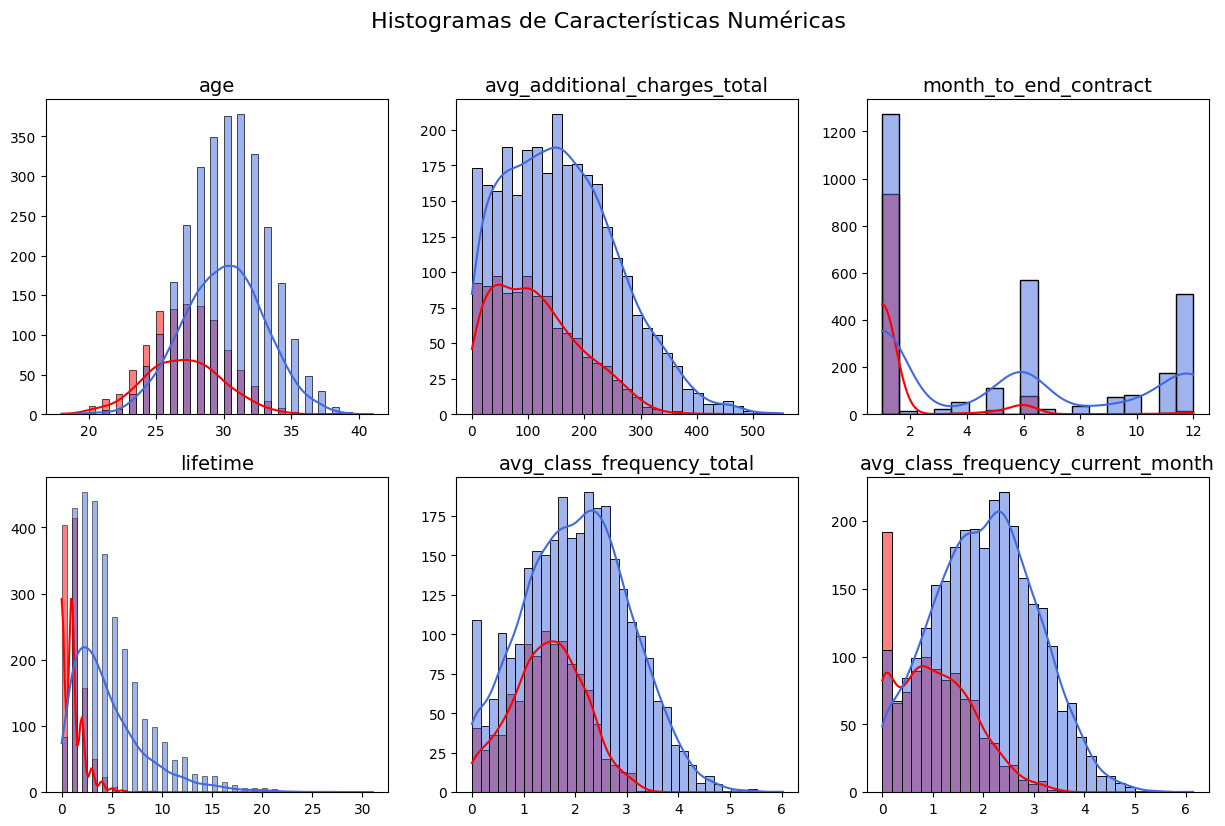

In [11]:
columns = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
cols = 'royalblue','red'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,9))
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        sns.histplot(x=columns[i], data=df, hue='churn', kde=True, palette=cols, ax=ax)
        ax.legend([], [], frameon=False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{columns[i]}', fontsize=14)
    else:
        ax.axis('off')
        
fig.suptitle('Histogramas de Características Numéricas', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

**Análisis**

Este gráfico nos permite observar la distribución de las variables numéricas en el dataset, diferenciando entre los usuarios que cancelaron su contrato (churn = 1) y los que no lo hicieron (churn = 0).

**Age:**
* Los usuarios que cancelaron su contrato tienden a ser ligeramente más jóvenes en comparación con los que no lo hicieron.
* La mayoría de los usuarios se concentran en un rango de edad entre 25 y 35 años, pero hay una ligera diferencia en la distribución entre ambos grupos.

**Avg_additional_charges_total:**
* Los usuarios que no cancelaron su contrato tienden a gastar más en servicios adicionales del gimnasio, como cafeterías o masajes.
* Los usuarios que cancelaron tienen una distribución más concentrada en valores bajos de gasto adicional.

**Month_to_end_contract:**
* Los usuarios que cancelaron su contrato tienen una mayor concentración en valores bajos (1 mes restante), lo que sugiere que **los contratos de corta duración están asociados con una mayor probabilidad de cancelación.**
* Los usuarios que no cancelaron tienen una distribución más uniforme en los meses restantes.

**Lifetime:**
* Los usuarios que cancelaron su contrato tienen un tiempo de vida como cliente significativamente menor, con una concentración en los primeros meses.
* Los usuarios que no cancelaron tienen una distribución más amplia, es decir, que han sido clientes por más tiempo.

**Avg_class_frequency_total:**
* Los usuarios que no cancelaron su contrato tienen una frecuencia promedio de asistencia más alta (entre 2 y 3), lo que sugiere que la participación activa en el gimnasio está relacionada con la retención.
* Los usuarios que cancelaron tienden a ir solamente entre 1 y 2 veces por semana.

**Avg_class_frequency_current_month:**
* Los usuarios que no cancelaron tienden a asistir más frecuentemente en el mes actual.
* Por otro lado, los usuarios que cancelaron muestran una disminución en la frecuencia de asistencia, lo que podría ser un **indicador temprano de cancelación.**

**Conclusión**

A simple vista, todas las varibles parecen mostrar comportamientos distintos entre los usuarios que cancelaron su contrato y aquellos que no lo hicieorn. Sin embargo, es necesario realizar un análisis más detallado, comenzando con la comparación de las variables cualitativas o binarias para identificar posibles redundancias entre características similares y eliminar aquellas que aporten información duplicada. 

Finalmente, es fundamental llevar a cabo pruebas de hipótesis para todas las variables con el objetivo de determinar cuáles tienen diferencias estadísticamente significativas y, por ende, son relevantes para incluir en el modelo de predicción.

**Matriz de correlación**

La matriz de correlación es una herramienta fundamental en el análisis exploratorio de datos, ya que nos permite identificar la **relación lineal** entre las variables numéricas del conjunto de datos. 

Este análisis es crucial para detectar posibles redundancias entre características, lo que puede simplificar el modelo y mejorar su rendimiento al e*liminar variables altamente correlacionadas que aportan información similar*. 

Además, la matriz de correlación nos ayuda a comprender mejor las interacciones entre las variables y su impacto potencial en la variable objetivo. El objetivo final es **seleccionar las características más relevantes y evitar multicolinealidad,** asegurando que el modelo de predicción sea más eficiente y preciso.

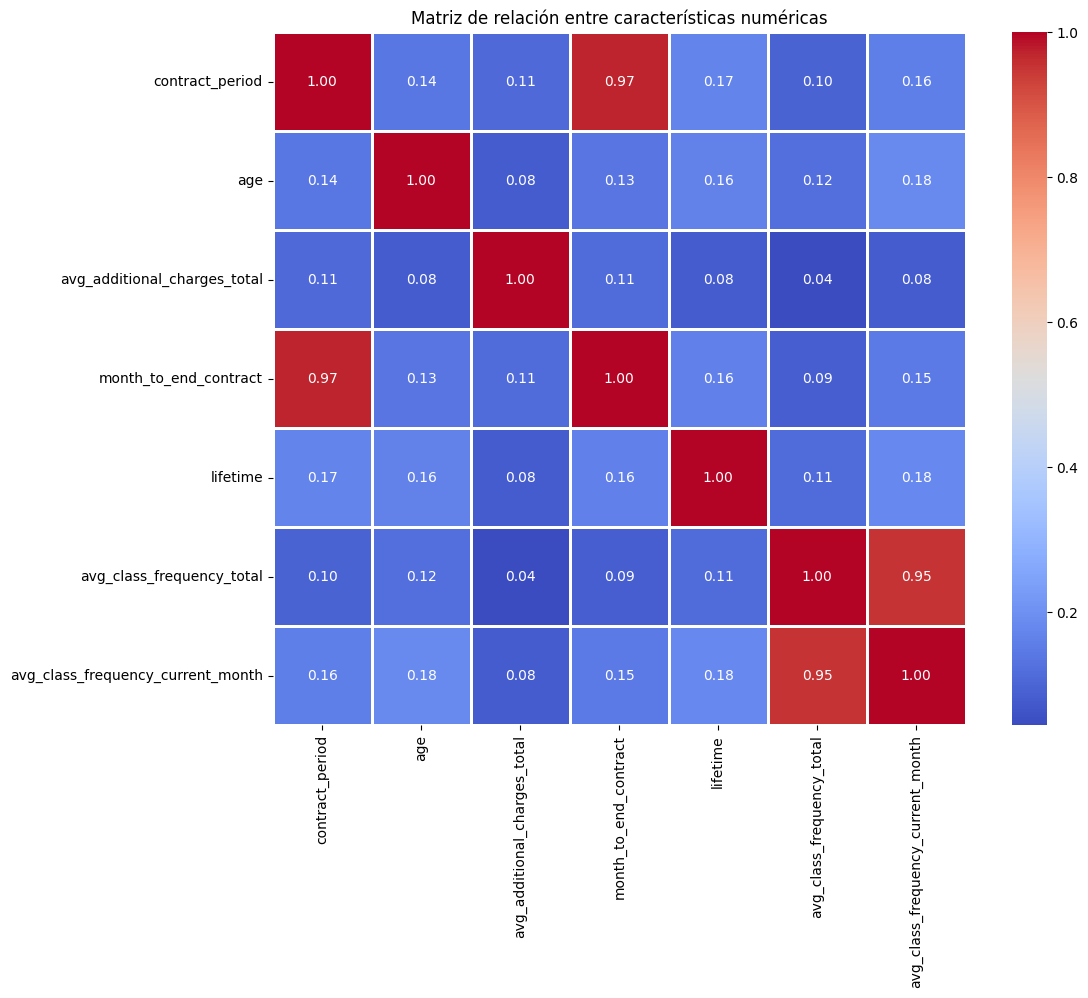

In [12]:
# Matriz de correlación
quant_cols = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

gym_churn_quant = df[quant_cols]

cm = gym_churn_quant.corr() 

plt.figure(figsize = (12, 9))
plt.title("Matriz de relación entre características numéricas")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=1, linecolor='white')
plt.show()

**Análisis**

* **contract_period y month_to_end_contract** están altamente correlacionadas, ya que ambas representan información *relacionada* con la duración del contrato. Dado que contract_period_ es más general y fácil de interpretar, **se recomienda eliminar month_to_end_contract.**

* Por otro lado, **avg_class_frequency_total y avg_class_frequency_current_month** también muestran una fuerte correlación, ya que ambas miden la frecuencia de asistencia aunque en diferentes periodos de tiempo. **Se sugiere eliminar avg_class_frequency_current_month** y mantener el otro, debido a que refleja un promedio más general.

**Tabla de contingencia de variables cualitativas**

La tabla de contingencia nos permite analizar la relación entre las variables cualitativas y la variable objetivo (churn). Su objetivo es identificar características categóricas que *no aportan información relevante* o que tienen una relación débil conla cancelación de usuarios.

Esto nos ayuda a reducir la *bidimensionalidad* del modelo y a enfocarnos en las varialbes más significativas.

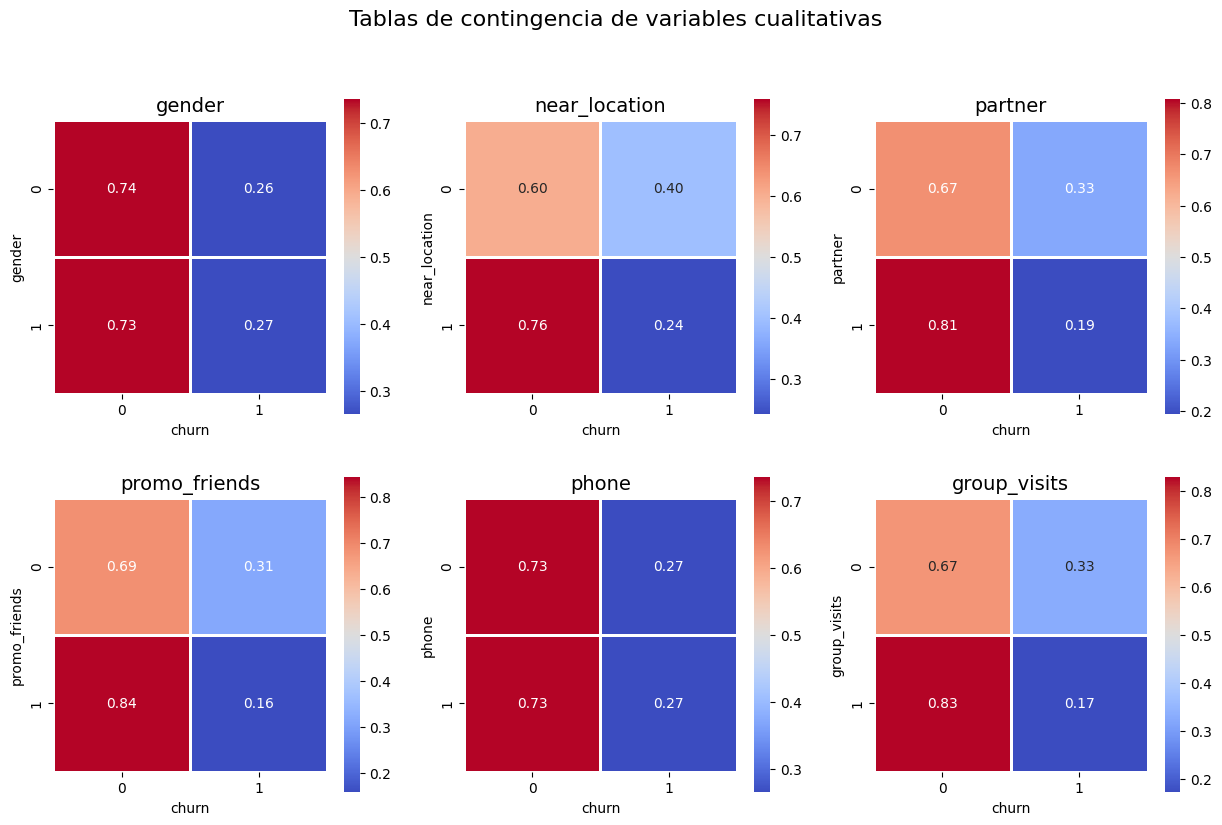

In [13]:
cat_cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']

cont_tables = []
for col in cat_cols:
    cont_table = pd.crosstab(index=df[col], columns=df['churn'], normalize='index')
    cont_tables.append(cont_table)

# Graficamos las tablas de contingencia
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,9))
for i, ax in enumerate(axs.flat):
    if i < len(cont_tables):
        sns.heatmap(cont_tables[i], annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=1, linecolor='white', ax=ax)
        ax.set_title(f'{cat_cols[i]}', fontsize=14)
    else:
        ax.axis('off')

plt.suptitle('Tablas de contingencia de variables cualitativas', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

**Análisis**

* Las variables **gender y phone** no muestran diferencias significativas entre los usuarios que canclearon y los que no. Por lo tanto, se recomienda **eliminar estas dos variables**.
* La variable **near_location** parece indicar que los usuarios que viven cerca del gimnasio tienen una ligera tendencia a permanecer más tiempo, pero la diferencia no es muy marcada. Se recomienda realizar una **prueba de hipótesis** para confirmar si esta variable tiene un impacto significativo antes de decidir si incluirlo en el modelo.
* Las variables **partner, promo_friends y group_visits** muestran que los usuarios que trabajan en empresas asociadas, los que se inscribieron mediante una promoción de amigos y los que participan en sesiones grupales, tienen una menor probabilidad de cancelar, lo que indica que estas variables son relevantes y útiles para el modelo.

**Conclusión**

Para reducir la bidimensionalidad y eliminar variables irrelevantes, se deben excluir las características:
* gender
* phone

### **ANÁLISIS DE RESULTADOS DEL EDA**

En el análisis exploratorio de datos (EDA) realizado hasta este punto nos permitió identificar patrones, relaciones y redundancias en las características del dataset. Este análisis es fundamental para comprender los factores que influyen en la cancelación de usuarios (churn) y para preparar los datos de manera adecuada antes de construir un modelo de predicción.

A continuación una breve conclusión de los hallazgos y pruebas adicionales que se realizarán para validar la relevancia de las variables.

1. La variable **churn** está desbalanceada, lo que puede afectar el rendimiento del modelo, ya que los algoritmos tienden a favorecer la clase mayoritaria. Consideraremos aplciar técnicas como ajuste de pesos en el modelo.
2. Los usuarios que cancelan tienden a ser más jovenes y tienen un menor tiempo de vida como clientes.
3. Los usuarios que cancelan gastan menos en servicios adicionales.
4. Los contratos de corta duración (1 mes) están asociados con una mayor probabilidad de cancelación.
5. Una menor frecuencia de asistencia está relacionada con la cancelación.
6. **Se eliminarán** las características '**month_to_end_contract**' y '**avg_class_frequency_current_month**' debido a su alta correlación y redundancia.
7. Las características **gender y phone** no muestran diferencias significativas entre los usuarios que cancelan y los que no, por lo que no aportan valor al modelo, y por consecuente **se eliminarán / no se tomarán en cuenta**
8. Los usuarios que trabajan en empreass asociadas (partner), los que se inscribieron mediante promociones de amigos (promo_riends) y los que participan en sesiones grupales (group_visits) tienen una menor probabilidad de cancelar.
9. Realizaremos una **prueba de hipótesis** a la característica **near_location** para confirmar si tiene un impacto significativo antes de decidir si incluirla en el modelo, ya que en la gráfica se ve una cierta diferencia pero no es muy clara, por lo que usaremos la prueba de hipótesis para estar seguros.

En resumen, para garantizar que las variables seleccionadas tienen diferencias estadísticamente significativas en relación con *churn*, se aplicarán las siguientes pruebas de hipótesis:
* Para variables numéricas:
    * Prueba t-student o U de Mann-Whitney:
        * age
        * avg_additional_charges_total
        * lifetime
        * avg_class_frequency_total
    
* Para variables categóricas:
    * Prueba de chi-cuadrado:
        * near_location
        * partner
        * promo_friends
        * group_visits

### **Prueba de hipótesis para variables numéricas**

**Hipótesis Nula (Ho):** No existe una diferencia estadísticamente significativa.

**Hipótesis Alternativa (H1):** Existe una diferencia estadísticamente significativa.

In [14]:
# Variables a analizar
variables_numericas = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']
target = 'churn'

# Función para realizar pruebas de hipótesis para variables numéricas
def pruebas_hipotesis_numericas(df, variables_numericas, target):
    resultados = {}
    for var in variables_numericas:
        grupo_0 = df[df[target] == 0][var]
        grupo_1 = df[df[target] == 1][var]
        
        # Prueba de normalidad (Shapiro-Wilk)
        stat_0, p_0 = stats.shapiro(grupo_0)
        stat_1, p_1 = stats.shapiro(grupo_1)
        
        # Si ambos grupos no son normales, usamos Mann-Whitney; de lo contrario, usamos t-test
        if p_0 < 0.05 or p_1 < 0.05:
            test_stat, p_value = stats.mannwhitneyu(grupo_0, grupo_1, alternative='two-sided')
            test_name = "Mann-Whitney U"
        else:
            test_stat, p_value = stats.ttest_ind(grupo_0, grupo_1, equal_var=False)
            test_name = "t-test"
        
        # Conclusión
        conclusion = "Se rechaza la hipótesis nula" if p_value < 0.05 else "No se rechaza la hipótesis nula"
        resultados[var] = {"Prueba": test_name, "p-valor": p_value, "Conclusión": conclusion}
    return resultados

# Realizamos las pruebas
resultados_numericos = pruebas_hipotesis_numericas(df, variables_numericas, target)

# Mostramos los resultados
print("Resultados de las pruebas de hipótesis para variables numéricas:")
for var, res in resultados_numericos.items():
    print(f"Variable: {var}, p-valor: {res['p-valor']:.4f}, Conclusión: {res['Conclusión']}")

Resultados de las pruebas de hipótesis para variables numéricas:
Variable: age, p-valor: 0.0000, Conclusión: Se rechaza la hipótesis nula
Variable: avg_additional_charges_total, p-valor: 0.0000, Conclusión: Se rechaza la hipótesis nula
Variable: lifetime, p-valor: 0.0000, Conclusión: Se rechaza la hipótesis nula
Variable: avg_class_frequency_total, p-valor: 0.0000, Conclusión: Se rechaza la hipótesis nula


En conlusión, las características age, avg_additional_charges_Total, lifetime y avg_class_frequency_total tienen una diferencia estadísticamente significativa entre sus valores, por lo que las tomaremos en cuenta en nuestro modelo.

### **Prueba de hipótesis para variables categóricas**

**Hipótesis Nula (Ho):** No existe una diferencia estadísticamente significativa.

**Hipótesis Alternativa (H1):** Existe una diferencia estadísticamente significativa.

In [15]:
# Variables a analizar
variables_categoricas = ['near_location', 'partner', 'promo_friends', 'group_visits']
target = 'churn'

# Función para realizar pruebas de hipótesis para variables categóricas
def pruebas_hipotesis_categoricas(df, variables_categoricas, target):
    resultados = {}
    for var in variables_categoricas:
        tabla_contingencia = pd.crosstab(df[var], df[target])
        test_stat, p_value, _, _ = stats.chi2_contingency(tabla_contingencia)
        
        # Conclusión
        conclusion = "Se rechaza la hipótesis nula" if p_value < 0.05 else "No se rechaza la hipótesis nula"
        resultados[var] = {"Prueba": "Chi-cuadrado", "p-valor": p_value, "Conclusión": conclusion}
    return resultados


# Realizamos las pruebas
resultados_categoricos = pruebas_hipotesis_categoricas(df, variables_categoricas, target)

# Mostramos los resultados
print("\nResultados de las pruebas de hipótesis para variables categóricas:")
for var, res in resultados_categoricos.items():
    print(f"Variable: {var}, p-valor: {res['p-valor']:.4f}, Conclusión: {res['Conclusión']}")


Resultados de las pruebas de hipótesis para variables categóricas:
Variable: near_location, p-valor: 0.0000, Conclusión: Se rechaza la hipótesis nula
Variable: partner, p-valor: 0.0000, Conclusión: Se rechaza la hipótesis nula
Variable: promo_friends, p-valor: 0.0000, Conclusión: Se rechaza la hipótesis nula
Variable: group_visits, p-valor: 0.0000, Conclusión: Se rechaza la hipótesis nula


En conclusión, las características near_location, partner, promo_friends y group_visits tienen una diferencia estadísticamente significativa, por lo que también las consideraremos en nuestro modelo.

## **MODELO DE CLASIFICACIÓN BINARIA PARA PREDECIR LA CANCELACIÓN DE USUARIOS**

**Modelo de Regresión Logística**

In [16]:
# Variables de características
X = df.drop(columns=['churn', 'gender', 'phone', 'month_to_end_contract', 'avg_class_frequency_current_month'])
# Variable objetivo
y = df['churn']
# Dividimos los datos en conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Normalizamos los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # Solo aplicamos las transofmraciones, no volvemos a entrenar porque si no vamos a estar filtrando información

# Creamos un modelo de regresión logística
model_lr = LogisticRegression(random_state=0)
model_lr.fit(X_train, y_train)

# Evaluamos el modelo
pred_lr = model_lr.predict(X_test)
pred_prob_lr = model_lr.predict_proba(X_test)[:,1]

In [17]:
predicciones = pd.DataFrame({
    'y_real' : y_test.values,
    'y_pred' : pred_lr,
}, index = y_test.index)

predicciones

,y_real,y_pred
2230,0,0
668,1,1
3616,0,1
2363,1,1
142,0,0
...,...,...
1118,1,1
3572,0,0
2482,0,0
643,0,0


In [18]:
# Evaluación del modelo
print("Regresión Logística:")
print("Accuracy:", accuracy_score(y_test, pred_lr)) # Indica en cuantas predicciones lo hizo bien
print("Precisión:", precision_score(y_test, pred_lr))
print("Recall:", recall_score(y_test, pred_lr)) # Cuantas acerto en los que se fugaron y no se fugaron
print("F1 Score:", f1_score(y_test, pred_lr))
print("AUC:", roc_auc_score(y_test, pred_prob_lr)) # Area bajo la curva ROC

Regresión Logística:
Accuracy: 0.895
Precisión: 0.7794117647058824
Recall: 0.803030303030303
F1 Score: 0.7910447761194029
AUC: 0.9533121916842847


**Modelo de Bosque Aleatorio**

In [19]:
# Creamos un modelo de Random Forest
model_rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=0)
# Entrenamos el modelo
model_rf.fit(X_train, y_train) 
# Realizamos predicciones
pred_rf = model_rf.predict(X_test)
pred_prob_rf = model_rf.predict_proba(X_test)[:,1]
predicciones['pred_rf'] = pred_rf

In [20]:
# Evaluación
print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, pred_rf))
print("Precisión:", precision_score(y_test, pred_rf))
print("Recall:", recall_score(y_test, pred_rf))
print("F1 Score:", f1_score(y_test, pred_rf))
print("AUC:", roc_auc_score(y_test, pred_prob_rf))

Random Forest:
Accuracy: 0.89125
Precisión: 0.7967914438502673
Recall: 0.7525252525252525
F1 Score: 0.7740259740259741
AUC: 0.94538407329105


Conclusión:

Ambos modelos tienen un resultado ligeramente similar, sin embargo, si comparamos accuracy=.95, precisión=.77 y recall=.80 de Regresión logística con accuracy=0.89, precisión=0.79 y recall=0.75 de Random Forest, podría decirse que **Regresión Logística tiene mejores resultados.**

## **CLÚSTERES DE USUARIOS**

Deja de lado la columna con datos sobre la cancelación e identifica los clústeres de objetos (usuarios/as):

1. Estandariza los datos.
2. Utiliza la función linkage() para crear una matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma. 
3. Entrena el modelo de clustering con el algortimo K-means y predice los clústeres de clientes. *(Deja que el número de clústeres sea n=5)*
4. Mira los valores medios de característica para los clústeres.¿Hay algo que te llame la atención?
5. Traza distribuciones de características para los clústeres. ¿Notas algo?
6. Calcula la tasa de cancelación para cada clúster (utiliza el método groupby()). ¿Difieren en términos de tasa de cancelación? ¿Qué grupos son propensos a irse y cuáles son leales?

In [21]:
# Creamos una nueva variable para aplicar clustering
df_cluster = df.drop('churn', axis=1)

# Estandarizamos los datos
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_cluster)

Text(0.5, 1.0, 'Dendrograma de las observaciones')

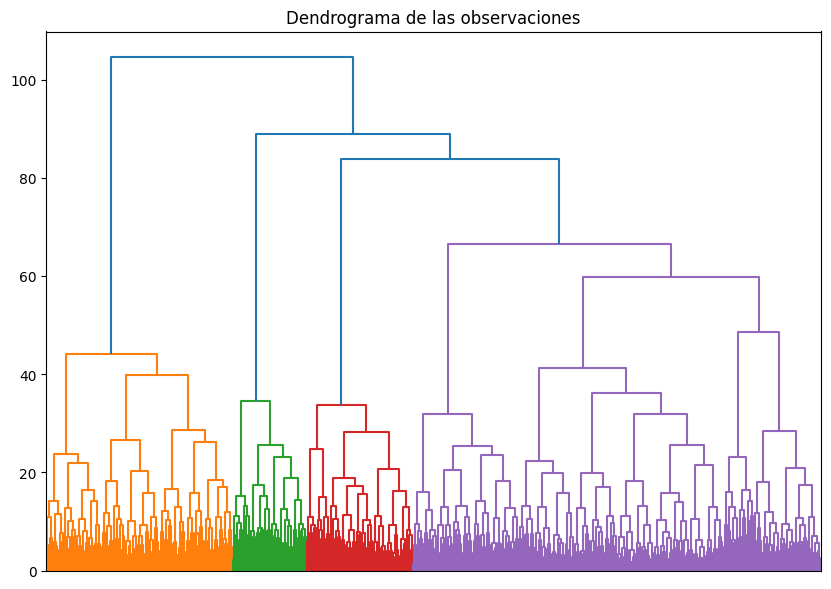

In [22]:
# Calculamos la distancia de los puntos
distance_matrix = pdist(X_cluster)

# Creamos el dendrograma
linkage_matrix = linkage(distance_matrix, method='ward')

# Personalizamos
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, no_labels=True, orientation='top')
plt.title('Dendrograma de las observaciones')

In [23]:
# Creamos el modelo de KMeans
km5 = KMeans(n_clusters=5, random_state=0)
# Entrenamos el modelo 
km5.fit(X_cluster)
# Predecimos los clusters
clusters = km5.predict(X_cluster)
# Agregamos los clusters al dataframe original
df['cluster'] = clusters

In [24]:
# Agrupamos por cluster y calculamos la media
cluster_means = df.groupby('cluster').mean()
cluster_means

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.486819,1.000000,0.243409,0.007030,0.899824,1.978910,0.326889,28.239016,130.877033,1.896309,2.477153,1.318003,1.083831,0.513181
1,0.592493,0.970509,0.288204,0.123324,0.898123,2.898123,0.482574,30.339142,164.193829,2.654155,5.219839,2.937411,2.944131,0.054960
2,0.499469,0.943677,0.740701,0.489904,0.900106,11.866100,0.551541,29.905420,165.146492,10.852285,4.737513,1.989423,1.980764,0.022317
3,0.483360,1.000000,0.798732,1.000000,0.911252,3.079239,0.445325,29.052298,139.858265,2.873217,3.510301,1.665722,1.547717,0.269414
4,0.496324,0.000000,0.466912,0.077206,0.915441,2.209559,0.215074,28.483456,133.630215,2.073529,2.781250,1.657657,1.466870,0.450368


**Carácterísticas de cada clúster** *en promedio*

**Clúster 0:**
* En promedio, todos los usuarios viven cerca del gimansio
* El 24% trabaja en una empresa afiliada, y casi nadie fue invitado por la promo_friends
* Los usuarios contratan 1 mes de gimnasio
* Al rededor del 32% de los usuarios suelen participar en sesiones grupales
* La edad promedio de los usuarios es de 28 años
* Suelen gastar $130 en servicios adicionales
* Los usuarios tienen entre 2 y 3 meses desde que entraron al gimnasio.
* Los usuarios van a 1 clase por semana
* El 51% de los usuarios tiende a **cancelar** su contrato.

**Clúster 1:**
* La mayoría de los usuarios vive cerca del gimnasio.
* El 28% trabaja en una empresa afiliada y solo el 12% fue invitado por la promo friends
* Los usuarios contratan entre 2 y 3 meses
* Al rededor del 48% de los usuarios suelen participar en sesiones grupales.
* La edad promedio de los usuarios es de 30 años
* Suelen gastar $164 en servicios adicionales
* Los usuarios tienen 5 meses desde que entraron al gimnasio
* La frecuencia de asistencia a clases ronda al rededor de 3 clases por semana
* El 95% de los usuarios **no cancelan** su contrato

**Clúster 2:**
* La mayoría de los usuarios vive cerca del gimnasio
* El 74% de los usuarios trabajan en una empresa afiliada, y el 48% fue invitado por la promo_friends
* La mayoría de los usuarios suelen contratar 12 meses de gimnasio
* Al rededor del 55% de los usuarios participan en sesiones grupales
* La edad promedio de los usuarios es de 29-30 años
* Suelen gastar $165 en servicios adicionales
* Los usuarios tienen al rededor de 4 meses desde que entraron al gimnasio
* La frecuencia de asistencia ronda al rededor de 2 clases por semana
* El 95% de los usuarios **no cancela** su contrato

**Clúster 3:**
* En promedio, todos los usuarios viven cerca del gimansio
* El 79% de los usuarios trabajan en una empresa afiliada, y en promedio el 100% fue invitado por la promo_friends
* La mayoría de los usuarios suelen contratar entre 1 y 3 meses de gimnasio
* Al rededor del 21% de los usuarios participan en sesiones grupales
* La edad promedio de los usuarios es de 28 años
* Suelen gastar $133 en servicios adicionales
* Los usuarios tienen al rededor de 2-3 meses desde que entraron al gimnasio
* La frecuencia de asistencia ronda al rededor de 1 clase por semana
* El 26% de los usuarios **cancela** su contrato

**Clúster 4:**
* Aquí los usuarios **no viven cerca** del gimnasio
* El 46% de los usuarios trabajan en una empresa afiliada, pero solo el 7% fue invitado por la promo_friends
* La mayoría de los usuarios suelen contratar 3 meses de gimnasio
* Al rededor del 44% de los usuarios participan en sesiones grupales
* La edad promedio de los usuarios es de 29 años
* Suelen gastar $140 en servicios adicionales
* Los usuarios tienen al rededor de 3-4 meses desde que entraron al gimnasio
* La frecuencia de asistencia ronda al rededor de 1 clase por semana
* El 45% de los usuarios **cancela** su contrato

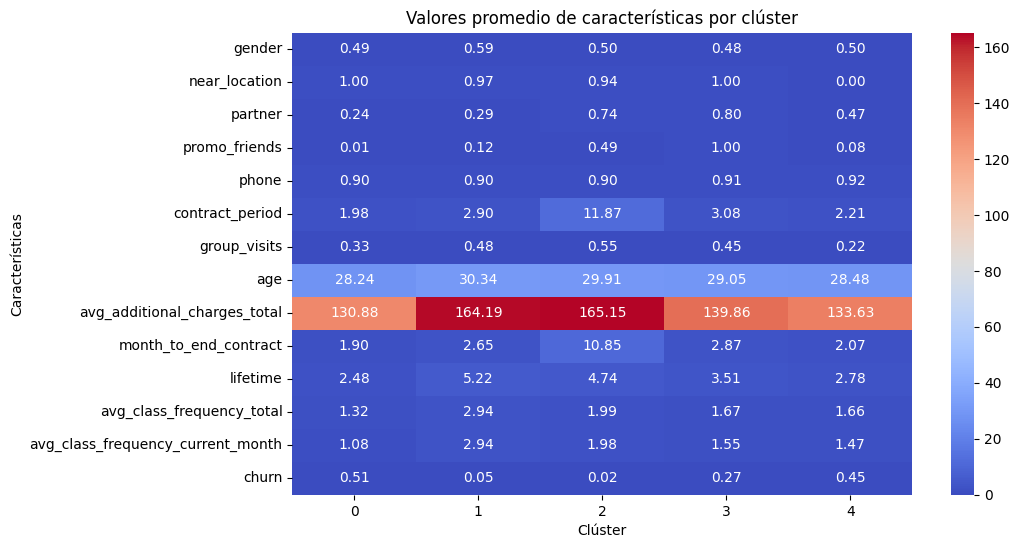

In [25]:
# Heatmap de valores promedio por clúster
cluster_means = df.groupby('cluster').mean()
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Valores promedio de características por clúster')
plt.xlabel('Clúster')
plt.ylabel('Características')
plt.show()

Para efectos prácticos, el análisis se hará respecto a la tasa de cancelación, que es nuestra variable objetivo y lo que queremos evitar.

En el mapa de calor, vemos que los clústeres que tienen una mayor tasa de cancelación son el 0 y 4. 

Dentro de sus características más relevantes se encuentran:
* La locación cercana: el clúser 0 si vive cerca, y el 4 no. 
* Comparando los datos de promo friends y parter, podría deducirse que si influye parcialmente que tengan estos descuentos o facilidades.
* Los meses contratados rondan entre 1 y 3 meses, aunque como vimos anteriormente, los usuarios que contratan 1 mes en su plan, tienden a cancelar
* Los usuarios de ambos clústeres suelen participar en menor medida en sesiones grupales
* La edad de los usuarios rondan al rededor de 28 años (más jóvenes que los que deciden quedarse)
* Y finalmente, la frecuencia media de visitas por semana es de 1 sesión (y va disminuyendo en el mes actual)

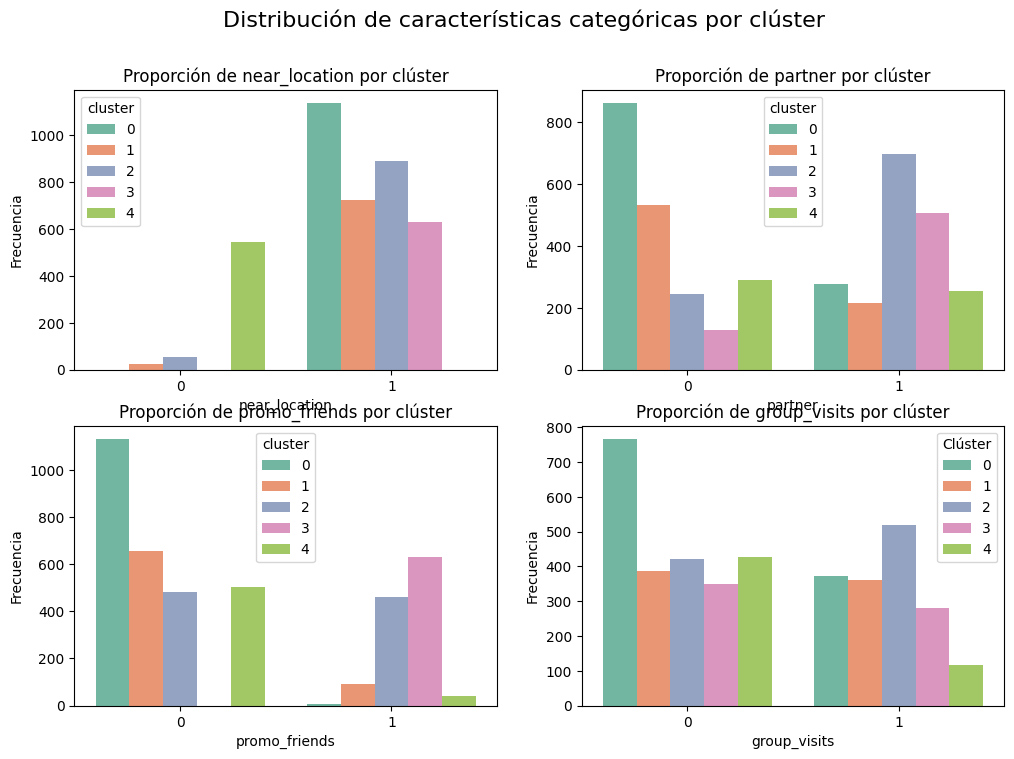

In [26]:
cluster_categorial_columns = ['near_location', 'partner', 'promo_friends', 'group_visits']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, ax in enumerate(axs.flat):
    if i < len(cluster_categorial_columns):
        sns.countplot(x=cluster_categorial_columns[i], hue='cluster', data=df, palette='Set2', ax=ax)
        ax.set_title(f'Proporción de {cluster_categorial_columns[i]} por clúster')
        ax.set_xlabel(cluster_categorial_columns[i])
        ax.set_ylabel('Frecuencia')
    else:
        ax.axis('off')

plt.legend(title='Clúster', loc='upper right')
fig.suptitle('Distribución de características categóricas por clúster', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

Nuevamente, enfocándonos en la variable objetivo (churn), los clústeres que suelen **cancelar** mayormente son:
* el clúster 4, por no vivir cerca del gimnasio
* el clúster 0 y 1 por no trabajar en una empresa afiliada
* nuevamente el clúster 0 y 1 por no haber sido invitados por amigos mediante la promoción. Sin embargo, pareciera que también influye en el clúster 4, ya que es la mayor cantidad de usuarios que cancelan que los que deciden quedarse.
* Y por último, generalmente la participación en sesiones grupales pareciera estar equilibrado. Sin embargo, el clúster 0 y 4 pareciera nos muestra que si afecta en la cancelación.

**Comparación gráfica de características por clústers**

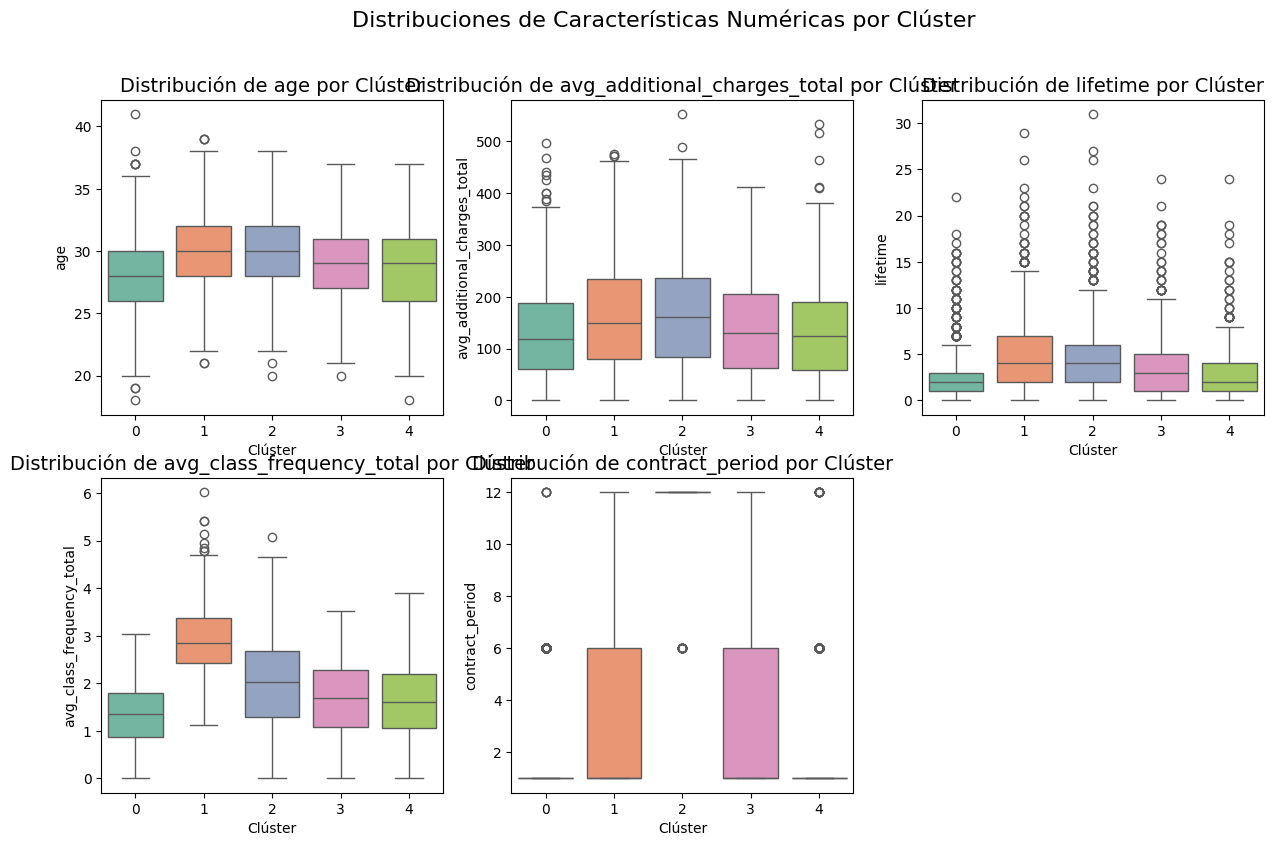

In [27]:
cluster_numerical_columns = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'contract_period']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))

for i, ax in enumerate(axs.flat):
    if i < len(cluster_numerical_columns):
        sns.boxplot(x='cluster', y=cluster_numerical_columns[i], data=df, hue='cluster', palette='Set2', ax=ax)
        ax.legend([], [], frameon=False)
        ax.set_title(f'Distribución de {cluster_numerical_columns[i]} por Clúster', fontsize=14)
        ax.set_xlabel('Clúster')
        ax.set_ylabel(cluster_numerical_columns[i])
    else:
        ax.axis('off')

fig.suptitle('Distribuciones de Características Numéricas por Clúster', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

Ya tenemos suficientes análisis con los datos anteriores, sin embargo, para reforzar lo visto, los boxplots nos indican que:
* **Age:** En el clúster 0, aunque en promedio nos había salido que los usuarios tenían 28 años, podemos ver que es el clúster con más valores atípicos, tanto en los rangos extremos mínimos como máximos. Es decir, en este clúster puede haber uno que otro usuario menor de 20 años y mayor que 35 años, sin embargo, no son muchos. 
* **Avg_additional_charges_total:** En la característica de cargos adicionales, el clúster 0 y 1 tienen más valores atípicos hacia la máxima, es decir, pareciera que a pesar de que estos grupos de personas tienden a cancelar más, suelen consumir también más en los servicios adicionales del gimnasio, pero como estamos hablando de valores atípicos, probablemente solo sean las personas que son más grandes, que tienen un trabajo más estable y pueden gastar más. Porque si nos ponemos a comparar las gráficas entre sí, el clúster 1 y 2 son los que realmente gastan más.
* **Lifetime:** Algunos clústeres tienen valores atípicos hacia el extremo superior, lo que indica que hay usuarios que han estado mucho tiempo en el gimnasio, aunque no sean representativos de la mayoría.
    * Clúster 0: Tiene un lifetime bajo en promedio, lo que indica que los usuarios de este clúster tienden a ser nuevos o no permanecen mucho tiempo en el gimnasio.
    * Clúster 1 y 2: Estos clústeres tienen un lifetime más alto en promedio, lo que sugiere que los usuarios de estos grupos son más leales y han estado más tiempo en el gimnasio.
    * Clúster 4: Similar al clúster 0, tiene un lifetime bajo, lo que podría estar relacionado con una mayor probabilidad de cancelación.
* **Avg_class_frequency_total:**
    * Clúster 0 y 4: Tienen una frecuencia promedio baja (alrededor de 1 clase por semana), lo que podría ser un indicador de desinterés o falta de compromiso, y podría estar relacionado con una mayor tasa de cancelación.
    * Clúster 1 y 2: Tienen frecuencias más altas (entre 2 y 3 clases por semana), lo que sugiere un mayor nivel de compromiso y una menor probabilidad de cancelación.
    * Clúster 3: Tiene una frecuencia intermedia, pero con menor dispersión, lo que indica que los usuarios de este clúster tienen un comportamiento más homogéneo.
* **Contract_period:** Los clústeres con contratos más cortos tienden a estar más asociados con la cancelación.

**Tasa de cancelación por clúster**

In [55]:
# Calcula la tasa de cancelación por clúster
churn_rate = cluster_means.reset_index()

*Como churn es binaria, el promedio representa la proporción de usuarios que cancelaron*

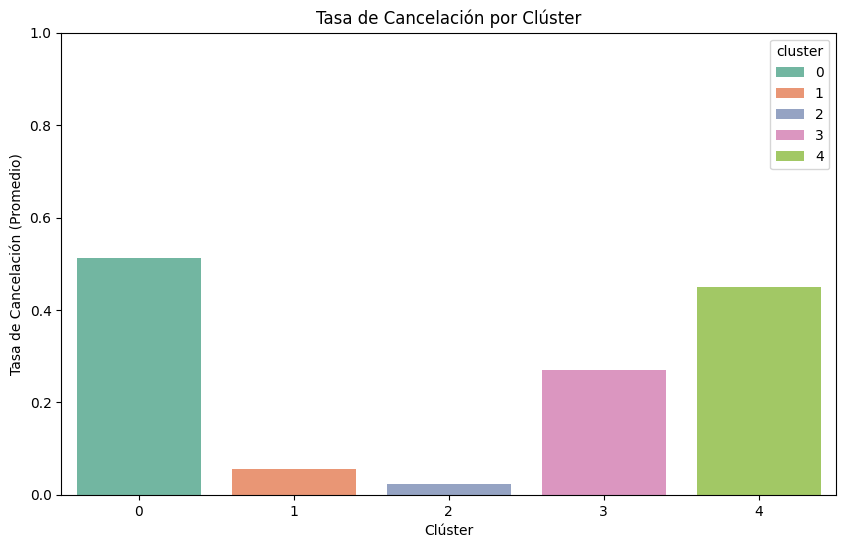

In [ ]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(10, 6))

# Gráfico de barras
sns.barplot(x='cluster', y='churn', hue='cluster', data=churn_rate, palette='Set2')

# Personalización del gráfico
plt.title('Tasa de Cancelación por Clúster')
plt.xlabel('Clúster')
plt.ylabel('Tasa de Cancelación (Promedio)')
plt.ylim(0, 1)

# Mostrar el gráfico
plt.show()

Como vimos anteriormente, el clúster 0 y 4 tienen mayores tasas de cancelación.

## **CONCLUSIONES**

El análisis realizado permitió identificar factores clave que impactan la pérdida de clientes en el gimnasio, así como patrones de comportamiento que pueden ser utilizados para diseñar estrategias efectivas de retención.

Dentro de los **factores que impactan la pérdida de clientes** son:
1. **Duración del contrato**
    * Los contratos de corta duración (1 mes) están altamente asociados con una mayor probabilidad de cancelación, en comparación con los más largos (6 o 12 meses).
2. **Frecuencia de asistencia**
    * Los usuarios que asisten con menor frecuencia (1 clase por semana o menos) tienen una mayor probabilidad de cancelar, ya que su participación activa está relacionada con la retención.
3. **Tiempo como cliente**
    * Los usuarios con menor tiempo en el gimnasio (2-3 meses) tienden a cancelar más. Esto sugiere que los primeros meses son críticos para establecer un compromiso a largo plazo.
4. **Participación en promociones y actividades grupales:**
    * Los usuarios que se inscribieron mediante promociones de amigos o participan en sesiones grupales tienen una menor probabilidad de cancelar
5. **Proximidad al gimansio**
    * Solamente un grupo de personas (clúster 4) vive lejos del gimnasio, lo que está relacionado con la cancelación del contrato. Sin embargo, de los 5 clústeres, solamente 1 vive lejos.

**Recomendaciones para mejorar la interacción y retención de clientes**

1. **Incentivar contratos más largos**. Se podrían ofrecer descuentos o beneficios adicionales para usuarios que opten por contratos de 6 o 12 meses.
2. **Fomentar la participación activa**. Un ejemplo sería diseñar programas que incentiven la asistencia regular al gimnasio.
3. **Mejorar la experiencia de los nuevos usuarios**. Enfocarse en los primeros meses es crucial para aumentar el compromiso de los clientes. 
4. **Promover actividades grupales y programas sociales**. Fometnar un sentido de comunidad entre los usuarios como eventos grupales, competencias internas o descuentos para usuarios que se inscriban con amigos o familiares podría ser una buena idea.

**Patrones adicionales observados**

Los usuarios jóvenes, en promedio 28 años, tienen un menor gasto en servicios adicionales y por tanto tienden a cancelar más. Esto podría estar relacionado a que estos podrían necesitar incentivos adicionales para comprometerse.

Por otro lado, las promociones como "promo_friends" tiene un impacto positivo en la retención. 

**Medidas para reducir la rotación**

Por último, implementar encuestas de satisfacción, crear programas de fidelización u ofrecer opciones de personalización en los planes de membresía podría favorcer la retención de los clientes y maximizar una experiencia positiva.

**Conclusión final**

La retención de clientes en el gimnasio depende de múltiples factores, como la duración del contrato, la frecuencia de asistencia, la participación en actividades grupales y la proximidad al gimnasio. Al implementar estrategias personalizadas basadas en estos factores, el gimnasio puede reducir significativamente la rotación y mejorar la experiencia general de los usuarios. Estas acciones no solo aumentarán la lealtad de los clientes, sino que también contribuirán al crecimiento sostenible del negocio.